### Ноутбук, чуть улучшающий результат.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Пойдем по пути: больше данных - лучше результаты.

In [2]:
x1_train = pd.read_csv('train/X1.csv')
x2_train = pd.read_csv('train/X2.csv')
y_train = pd.read_csv('train/Y.csv')

x1_test = pd.read_csv('test/X1.csv')
x2_test = pd.read_csv('test/X2.csv')

In [3]:
x1_train = x1_train.fillna(x1_train.mean())
x1_test = x1_test.fillna(x1_train.mean())

In [4]:
train = x1_train.join(y_train.set_index('id'), on='id', rsuffix='_target')

In [5]:
len(x2_train.A.unique())

134369

In [8]:
site_ids_train = x2_train.A.value_counts().index.values[x2_train.A.value_counts() > 100]
site_ids_test = x2_test.A.value_counts().index.values[x2_test.A.value_counts() > 100]

In [13]:
site_ids = np.array(list(set(site_ids_train).intersection(site_ids_test)))

In [14]:
x2_train_new = []
for row in x1_train.iterrows():
    current_id = row[1]['id']
    current_pd = x2_train[x2_train.id == current_id]
    current_pd = current_pd.A[current_pd.A.isin(site_ids)]
    new_features = np.zeros(len(site_ids) + 2)
    for site_id in current_pd:
        site_index = np.where(site_ids == site_id)[0][0]
        new_features[site_index] += 1
    new_features[-2] = current_id
    new_features[-1] = len(x2_train[x2_train.id == current_id])
    x2_train_new.append(new_features)

In [15]:
x2_train_new_pd = pd.DataFrame(x2_train_new, columns=list(site_ids) + ['id', 'site_counts'])

In [16]:
train_new = train.join(x2_train_new_pd.set_index('id'), on='id', rsuffix='_x2')

График корреляции признаков, по которому ничего нельзя сказать.

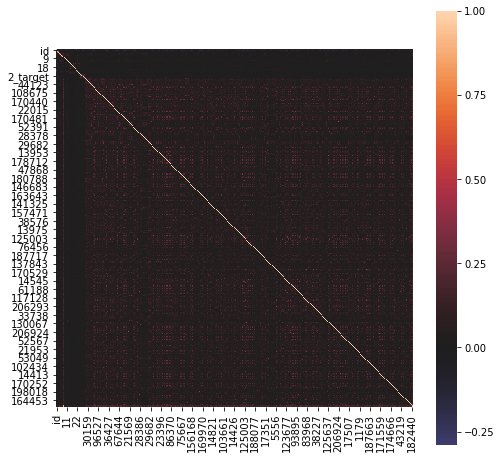

In [90]:
corrmat = train_new.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corrmat, square=True, center=0)
plt.show()

Снова пойдем по пути наименьшего сопротивления и подберем параметры для RF.

In [17]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2)

In [18]:
train_params_dict = {}
for c in y_train.columns[1:]:
    train_params_dict[f'{c}_target'] = {}

In [19]:
features = train_new.drop(columns=['id', '1_target', '2_target', '3_target', '4_target', '5_target'])
targets = train_new[['1_target', '2_target', '3_target', '4_target', '5_target']]
for target_name in train_params_dict:
    for train_val_index, test_index in sss.split(features, targets[[target_name]]):
        continue
    train_params_dict[target_name]['train_val_index'] = train_val_index
    train_params_dict[target_name]['test_index'] = test_index

In [20]:
params = {
    'n_estimators': [5, 10, 50, 100, 150],
    'max_depth': [None, 1, 2, 3, 4],
    'min_samples_split': [2, 3, 4],
}

In [21]:
for target_name in train_params_dict:
    rf = RandomForestRegressor(criterion="mse")
    clf = GridSearchCV(rf, params, cv=sss, error_score='raise', scoring='roc_auc', verbose=1)
    train_val_index = train_params_dict[target_name]['train_val_index']
    train_val_data = features.iloc[train_val_index]
    train_val_target = targets[target_name].iloc[train_val_index]
    clf.fit(train_val_data, train_val_target)
    train_params_dict[target_name]['clf'] = clf

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  3.8min finished


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  3.6min finished


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  4.0min finished


In [22]:
for target_name in train_params_dict:
    test_index = train_params_dict[target_name]['test_index']
    test_data = features.iloc[test_index]
    test_target = targets[target_name].iloc[test_index]
    prediction = train_params_dict[target_name]['clf'].predict(test_data)
    prediction = np.array(list(map(lambda x: min(max(x, 0), 1), prediction)))
    test_score = roc_auc_score(test_target, prediction)
    train_params_dict[target_name]['test_score'] = test_score

In [23]:
for target_name in train_params_dict:
    print(target_name, train_params_dict[target_name]['test_score'])

1_target 0.6183810980340004
2_target 0.6092670200660542
3_target 0.6131054796751422
4_target 0.5974096060442524
5_target 0.5719843297564299


In [24]:
x2_test_new = []
for row in x1_test.iterrows():
    current_id = row[1]['id']
    current_pd = x2_test[x2_test.id == current_id]
    current_pd = current_pd.A[current_pd.A.isin(site_ids)]
    new_features = np.zeros(len(site_ids) + 2)
    for site_id in current_pd:
        site_index = np.where(site_ids == site_id)[0][0]
        new_features[site_index] += 1
    new_features[-2] = current_id
    new_features[-1] = len(x2_test[x2_test.id == current_id])
    x2_test_new.append(new_features)

In [25]:
x2_test_new_pd = pd.DataFrame(x2_test_new, columns=list(site_ids) + ['id', 'site_counts'])

In [28]:
test_new = x1_test.join(x2_test_new_pd.set_index('id'), on='id', rsuffix='_x2')

In [30]:
x1_test_features = test_new.drop(columns=['id'])

In [31]:
submission = {'id': x1_test.id}
for i, target_name in enumerate(train_params_dict, 1):
    test_prediction = train_params_dict[target_name]['clf'].predict(x1_test_features)
    test_prediction = np.array(list(map(lambda x: min(max(x, 0), 1), test_prediction)))
    submission[str(i)] = test_prediction

In [32]:
submission_pd = pd.DataFrame(submission)

In [34]:
submission_pd.to_csv('random_forest_x1_x2_simple.csv', index=False)

P.S. Была попытка объединить 2 наилучших результата, но она провалилась

![sad_pepe](https://i.imgur.com/ESTvJMn.jpg)